# Steady State Response

Based on the data that are obtained, they will be fitted to the function below

$\displaystyle{ \hat{u}_s = \beta_1 \left(1 - e^{\beta_2 v_s + \beta_3 \sqrt[10]{v_s}} \right) }$

where $u_s$ is throttle, $v_s$ is steady-state speed for a constant input, and $\beta_1, \beta_2, \beta_3 \in \Re$

The cost function that will be minimized using PSO, APSO, and BSO is stated below

$ \displaystyle{
J = \frac{1}{M} \sum_{i=1}^M \left(u_s - \hat{u}_s \right)^2
} $

The constraints that will be used when minimizing are

$ \displaystyle{
    \beta_1 \geq 0
} $

$\displaystyle{
\beta_2, \beta_3 \leq 0
}$

## Import Libraries and Data

In [1]:
import numpy as np
import numba as nb
import math
import matplotlib.pyplot as plt
import pandas as pd
import time
import random
from numba import jit, njit, types, vectorize, prange
from numba import jitclass, int32, float32, int64, float64
from numba.typed import List
from multiprocessing import Pool
from os import listdir
from os.path import isfile, join
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('data/steady_state_velocity.csv')
v0 = np.array(df.speed[1:])
u0 = np.array(df.throttle[1:])

## Data Plot

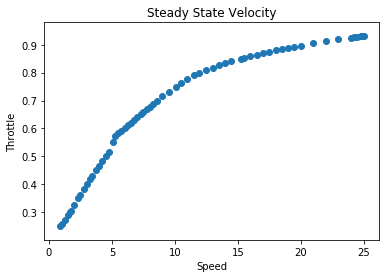

In [3]:
plt.title('Steady State Velocity')
plt.xlabel('Speed')
plt.ylabel('Throttle')
plt.scatter(v0, u0)
plt.show()

## Functions

Cost Function

In [4]:
@njit
def cost(beta):
    b1, b2, b3 = beta
    u = b1*(1.0 - np.exp(b2*v0 + b3*v0**(0.1)))
    err = np.abs(u - u0)
    if(b1<0 or b2>0 or b3>0):
        return np.inf
    return np.mean(err**2)

_ = cost(np.array([0.1,0.1,0.1]))

Evaluation Function (for plotting results)

In [6]:
@njit
def ev_func(beta):
    b1, b2, b3 = beta
    u = b1*(1.0 - np.exp(b2*v0 + b3*v0**(0.1)))
    return u

_ = cost([0.1,0.1,0.1])

PSO Algorithm

In [7]:
@njit
def PSO(c_func, n_param, particles, lb, ub, iterate_max):
    # Define the constants
    w = 0.5
    c1 = 0.8
    c2 = 0.7
    iterate = 0
    
    # Setup the initial conditions for position and velocity arrays
    ppos_vector = np.random.uniform(lb, ub, (particles, n_param))
    pbest_pos = ppos_vector
    pfit_value = np.ones(particles) * 1e100
    gbest_pos = np.zeros(n_param)
    gfit_value = 1e100
    pvel_vector = np.zeros((particles, n_param))
    
    # First loop for assigning the fitness value using the cost function
    for i in range(particles):
        # Check the position of individual and group value using the evaluation function
        cost_func = c_func(ppos_vector[i])
        
        # Update each values using the cost functions
        if(pfit_value[i] > cost_func):
            pfit_value[i] = cost_func
            pbest_pos[i] = np.copy(ppos_vector[i])
                
        if(gfit_value > cost_func):
            gfit_value = cost_func
            gbest_pos = np.copy(ppos_vector[i])
        
    # Second loop for implementing the PSO Algorithm
    while (iterate < iterate_max):
        for i in range(particles):
            # Update the velocity and position vector
            pvel_vector[i] = w*pvel_vector[i] + c1*random.random()*(pbest_pos[i]-ppos_vector[i]) + c2*random.random()*(gbest_pos-ppos_vector[i])
            ppos_vector[i] = pvel_vector[i] + ppos_vector[i]
            
            cost_func = c_func(ppos_vector[i])
            
            # Update each values using the cost functions
            if(pfit_value[i] > cost_func):
                pfit_value[i] = cost_func
                pbest_pos[i] = np.copy(ppos_vector[i])
                
            if(gfit_value > cost_func):
                gfit_value = cost_func
                gbest_pos = np.copy(ppos_vector[i])
        
        iterate = iterate+1
        print("Iteration: ", iterate, " | Global best cost: ", c_func(gbest_pos))
    
    gbest_loss = c_func(gbest_pos)
    
    print("The best position for each parameter: ", gbest_pos, " with ", iterate, " iteration.")
    return gbest_pos, gbest_loss

_ = PSO(cost, 3, 1, -1.0, 1.0, 1)

Iteration:  1  | Global best cost:  0.051253451599219534
The best position for each parameter:  [ 0.55795794 -0.33069258 -0.98321081]  with  1  iteration.


APSO Algorithm

In [8]:
def APSO(c_func, n_param, particles, lb, ub, iterate_max):
    # Define the constants
    alpha0 = 0.6
    beta = 0.4
    gamma = 0.5
    iterate = 0
    
    # Setup the initial conditions for position and velocity arrays
    ppos_vector = np.random.uniform(lb, ub, (particles, n_param))
    gbest_pos = np.zeros(n_param)
    gfit_value = 1e100
    
    # First loop for assigning the fitness value using the cost function
    for i in range(particles):
        # Check the position of individual and group value using the evaluation function
        cost_func = c_func(ppos_vector[i])
        
        # Update the global value using the cost functions
        if(gfit_value > cost_func):
            gfit_value = np.copy(cost_func)
            gbest_pos = np.copy(ppos_vector[i])
            
    # Second loop for implementing the APSO Algorithm
    while (iterate < iterate_max):
        for i in range(particles):
            # Update the alpha value
            alpha = alpha0*gamma**iterate
            
            # Update the velocity and position vector
            ppos_vector[i] = (1-beta)*ppos_vector[i] + alpha*np.random.normal(0,1) + beta*gbest_pos
            
            cost_func = c_func(ppos_vector[i])
            
            # Update the global value using the cost functions
            if(gfit_value > cost_func):
                gfit_value = np.copy(cost_func)
                gbest_pos = np.copy(ppos_vector[i])
        
        iterate = iterate+1
        print("Iteration: ", iterate, " | Global best cost: ", c_func(gbest_pos))
    
    gbest_loss = c_func(gbest_pos)
    
    print("The best position for each parameter: ", gbest_pos, " with ", iterate, " iteration.")
    return gbest_pos, gbest_loss

_ = APSO(cost, 3, 1, -1.0, 1.0, 1)

Iteration:  1  | Global best cost:  0.49501226923076924
The best position for each parameter:  [0. 0. 0.]  with  1  iteration.


BSO Algorithm

In [9]:
def cluster_center(clust, c_func):
    ranked = np.zeros([clust.shape[0], clust.shape[1] + 1])
    
    for i in range(clust.shape[0]):
        for j in range(clust.shape[1]):
            ranked[i][j] = clust[i][j]
        ranked[i][j+1] = c_func(clust[i])
    
    ranked = np.delete(ranked[ranked[:,-1].argsort()], -1, axis=1)
    
    return ranked[0]

In [10]:
def logsig(x):
    return 1 / (1 + math.exp(-x))

In [11]:
def BSO(c_func, n_param, n_ideas, lb, ub, max_iterate):
    # Define initial parameters
    ideas = np.random.uniform(lb, ub, (n_ideas, n_param))
    Km = KMeans(n_clusters=3, max_iter=50)
    iterate = 0
    k = 20
    new_ideas = np.zeros([n_ideas, n_param])
    
    # Define the probabilities
    p_one = 0.8
    p_one_center = 0.4
    p_two_center = 0.5
    
    # Main BSO Loop
    while(iterate < max_iterate):
        print("Clusterizing", end="")
        
        # Clusterize the ideas
        print(".", end="")
        cluster = Km.fit_predict(ideas)
        cl1 = ideas[cluster == 0]
        cl2 = ideas[cluster == 1]
        cl3 = ideas[cluster == 2]
        clusters = [cl1, cl2, cl3]
        print(".", end="")
        
        # Generate n new ideas
        for i in range(ideas.shape[0]):
            # New idea based on one cluster
            if np.random.random() < p_one:
                cl_selected = random.choice(clusters)
                cl_selected_center = cluster_center(cl_selected,  c_func)
                
                # Use the previous cluster center
                if np.random.random() < p_one_center:
                    new_ideas[i] = cl_selected_center
                
                # Use random idea in a cluster
                else:
                    new_ideas[i] = random.choice(cl_selected)
            
            # New idea based on two cluster
            else:
                cl_selected1, cl_selected2 = random.sample(clusters, 2)
                cl_selected_center1 = cluster_center(cl_selected1, c_func)
                cl_selected_center2 = cluster_center(cl_selected2, c_func)
                rand = np.random.random()
                
                # Use the combination of two previous cluster centers
                if np.random.random() < p_two_center:
                    new_ideas[i] = rand*cl_selected_center1 + (1-rand)*cl_selected_center2
                    
                # Use two random ideas in a cluster
                else:
                    new_ideas[i] = rand*random.choice(cl_selected1) + (1-rand)*random.choice(cl_selected2)
            
            eps = logsig((0.5*max_iterate - iterate)/k)
            upd_new_ideas = np.copy(new_ideas[i]) + eps*np.random.normal(0, 1)
            
            if(c_func(upd_new_ideas) < c_func(new_ideas[i])):
                new_ideas[i] = upd_new_ideas
        
        print(". Ideas Generated!", end="")
        
        ideas = new_ideas
        iterate = iterate + 1
        print(" | Iteration: ", iterate)
    
    # Reclusterize ideas
    print("Clusterizing")
    cluster = Km.fit_predict(ideas)
    cl1 = ideas[cluster == 0]
    cl2 = ideas[cluster == 1]
    cl3 = ideas[cluster == 2]
    clusters = np.array([cl1, cl2, cl3])
    
    # Choose the best cluster center for the output
    for i in range(clusters.shape[0]):
        cl1_center = cluster_center(cl1, c_func)
        cl2_center = cluster_center(cl2, c_func)
        cl3_center = cluster_center(cl3, c_func)
    
    possible_ideas = np.array([cl1_center, cl2_center, cl3_center])
    idea_out = cluster_center(possible_ideas, c_func)
    idea_loss = c_func(idea_out)
    
    print("The best idea is ", idea_out, " with a cost of ", c_func(idea_out))
    
    return idea_out, idea_loss

_ = BSO(cost, 3, 10, -1.0, 1.0, 1)

Clusterizing... Ideas Generated! | Iteration:  1
Clusterizing
The best idea is  [ 0.38913994 -0.74072028 -0.04962111]  with a cost of  0.12435792658817003


## Parameter Search

Value Search

In [12]:
pso_best, pso_loss = PSO(cost, 3, 200, -1, 1, 500)

Iteration:  1  | Global best cost:  0.005639877615683566
Iteration:  2  | Global best cost:  0.0031232775381250153
Iteration:  3  | Global best cost:  0.0001983566102159633
Iteration:  4  | Global best cost:  0.0001983566102159633
Iteration:  5  | Global best cost:  9.879244441460341e-05
Iteration:  6  | Global best cost:  9.879244441460341e-05
Iteration:  7  | Global best cost:  8.725185850667026e-05
Iteration:  8  | Global best cost:  7.677369564369737e-05
Iteration:  9  | Global best cost:  7.589308410570569e-05
Iteration:  10  | Global best cost:  7.294246678962359e-05
Iteration:  11  | Global best cost:  7.227089147045809e-05
Iteration:  12  | Global best cost:  7.227089147045809e-05
Iteration:  13  | Global best cost:  7.227089147045809e-05
Iteration:  14  | Global best cost:  7.227089147045809e-05
Iteration:  15  | Global best cost:  7.199227483321716e-05
Iteration:  16  | Global best cost:  7.199227483321716e-05
Iteration:  17  | Global best cost:  7.194972818048051e-05
Iterati

In [13]:
apso_best, apso_loss = APSO(cost, 3, 200, -1, 1, 500)

Iteration:  1  | Global best cost:  0.002947100034564963
Iteration:  2  | Global best cost:  0.0010970935512698557
Iteration:  3  | Global best cost:  0.0010970935512698557
Iteration:  4  | Global best cost:  0.00021561261802051184
Iteration:  5  | Global best cost:  0.00010531265673148312
Iteration:  6  | Global best cost:  0.00010531265673148312
Iteration:  7  | Global best cost:  7.834338911952259e-05
Iteration:  8  | Global best cost:  7.372904571928514e-05
Iteration:  9  | Global best cost:  7.31568097922951e-05
Iteration:  10  | Global best cost:  7.312791571651457e-05
Iteration:  11  | Global best cost:  7.228190817929738e-05
Iteration:  12  | Global best cost:  7.225640520477865e-05
Iteration:  13  | Global best cost:  7.210855584082704e-05
Iteration:  14  | Global best cost:  7.205535286019359e-05
Iteration:  15  | Global best cost:  7.202051200887043e-05
Iteration:  16  | Global best cost:  7.199818609782711e-05
Iteration:  17  | Global best cost:  7.199818609782711e-05
Itera

In [25]:
bso_best, bso_loss = BSO(cost, 3, 200, -1.0, 1.0, 500)

Clusterizing... Ideas Generated! | Iteration:  1
Clusterizing... Ideas Generated! | Iteration:  2
Clusterizing... Ideas Generated! | Iteration:  3
Clusterizing... Ideas Generated! | Iteration:  4
Clusterizing... Ideas Generated! | Iteration:  5
Clusterizing... Ideas Generated! | Iteration:  6
Clusterizing... Ideas Generated! | Iteration:  7
Clusterizing... Ideas Generated! | Iteration:  8
Clusterizing... Ideas Generated! | Iteration:  9
Clusterizing... Ideas Generated! | Iteration:  10
Clusterizing... Ideas Generated! | Iteration:  11
Clusterizing... Ideas Generated! | Iteration:  12
Clusterizing... Ideas Generated! | Iteration:  13
Clusterizing... Ideas Generated! | Iteration:  14
Clusterizing... Ideas Generated! | Iteration:  15
Clusterizing... Ideas Generated! | Iteration:  16
Clusterizing... Ideas Generated! | Iteration:  17
Clusterizing... Ideas Generated! | Iteration:  18
Clusterizing... Ideas Generated! | Iteration:  19
Clusterizing... Ideas Generated! | Iteration:  20
Clusteriz

Save Searched Values

In [26]:
np.save('results/pso_best.npy', pso_best)
np.save('results/pso_loss.npy', pso_loss)
np.save('results/apso_best.npy', apso_best)
np.save('results/apso_loss.npy', apso_loss)
np.save('results/bso_best.npy', bso_best)
np.save('results/bso_loss.npy', bso_loss)

## Results

Load the Values

In [27]:
pso_best = np.load('results/pso_best.npy')
pso_loss = np.load('results/pso_loss.npy')
apso_best = np.load('results/apso_best.npy')
apso_loss = np.load('results/apso_loss.npy')
bso_best = np.load('results/bso_best.npy')
bso_loss = np.load('results/bso_loss.npy')

Plot for Values

### PSO

In [17]:
print("Parameters: ", pso_best)
print("Cost value: ", pso_loss)

Parameters:  [ 0.95959429 -0.12973389 -0.15346456]
Cost value:  7.193799405427695e-05


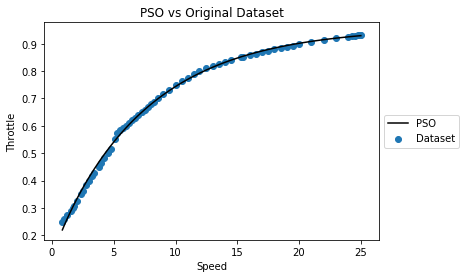

In [18]:
plt.title('PSO vs Original Dataset')
plt.xlabel('Speed')
plt.ylabel('Throttle')
plt.plot(v0, ev_func(pso_best), label='PSO', color='k')
plt.scatter(v0, u0, label='Dataset')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### APSO

In [19]:
print("Parameters: ", apso_best)
print("Cost value: ", apso_loss)

Parameters:  [ 0.96004277 -0.12933282 -0.15458761]
Cost value:  7.199193255902009e-05


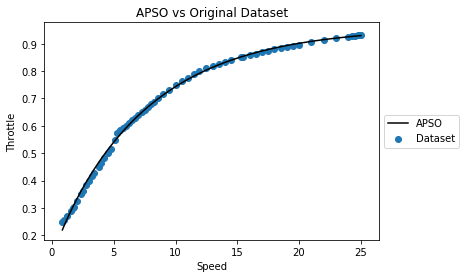

In [24]:
plt.title('APSO vs Original Dataset')
plt.xlabel('Speed')
plt.ylabel('Throttle')
plt.plot(v0, ev_func(apso_best), label='APSO', color='k')
plt.scatter(v0, u0, label='Dataset')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### BSO

In [28]:
print("Parameters: ", bso_best)
print("Cost value: ", bso_loss)

Parameters:  [ 0.92850223 -0.14662813 -0.12515952]
Cost value:  0.00017046012655520698


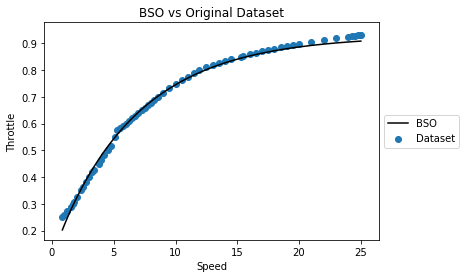

In [29]:
plt.title('BSO vs Original Dataset')
plt.xlabel('Speed')
plt.ylabel('Throttle')
plt.plot(v0, ev_func(bso_best), label='BSO', color='k')
plt.scatter(v0, u0, label='Dataset')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()